In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [38]:
df = pd.read_excel('HaSample3Y.xlsx')

In [39]:
print(df)

    Week Start     Bookings
0   2021-08-01   385.520873
1   2021-08-08   290.988905
2   2021-08-15   429.624335
3   2021-08-22   605.104608
4   2021-08-29   509.228475
..         ...          ...
151 2024-06-23   420.453159
152 2024-06-30   343.655794
153 2024-07-07   424.127625
154 2024-07-14   569.688425
155 2024-07-21  1279.608535

[156 rows x 2 columns]


In [40]:
df.set_index('Week Start',inplace=True)

In [41]:
df.head()

,Bookings
Week Start,
2021-08-01,385.520873
2021-08-08,290.988905
2021-08-15,429.624335
2021-08-22,605.104608
2021-08-29,509.228475


In [42]:
df.describe()

,Bookings
count,156.000000
mean,479.127974
std,281.458166
min,115.436058
25%,325.642219
50%,404.949307
75%,525.250246
max,1772.016998


In [45]:
#Step 2. Visualize the Data

<Axes: xlabel='Week Start'>

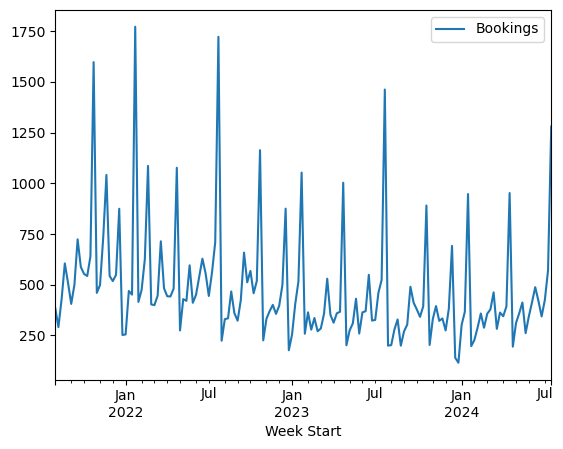

In [43]:
df.plot()

In [44]:
###Testing for Stationarity

from statsmodels.tsa.stattools import adfuller

In [45]:
#Null Hypo: It is non stationary
#Alternate Hypo: It is stationary

def adfuller_test(Bookings):
    result=adfuller(Bookings)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value, label in zip(result,labels):
        print(label+':'+str(value))
    if result[1] <=.05:
        print("Strong evidence against null hypo")
    else:
        print("Weak evidence against null hypo")

In [46]:
adfuller_test(df['Bookings'])

ADF Test Statistic:-1.6090451415747158
p-value:0.4790484101045573
#Lags Used:13
Number of Observations Used:142
Weak evidence against null hypo


In [47]:
#### If it is non stationary we have to make it Stationary
### Differencing
df['Seasonal First Difference']=df['Bookings']-df['Bookings'].shift(4)

In [48]:
df.head(15)

,Bookings,Seasonal First Difference
Week Start,,
2021-08-01,385.520873,NaN
2021-08-08,290.988905,NaN
2021-08-15,429.624335,NaN
2021-08-22,605.104608,NaN
2021-08-29,509.228475,123.707602
2021-09-05,405.504429,114.515524
2021-09-12,499.804035,70.179700
2021-09-19,723.763450,118.658842
2021-09-26,587.689166,78.460691


In [49]:
### Again performing adfuller_test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic:-5.271027945945186
p-value:6.285286758136115e-06
#Lags Used:13
Number of Observations Used:138
Strong evidence against null hypo


<Axes: xlabel='Week Start'>

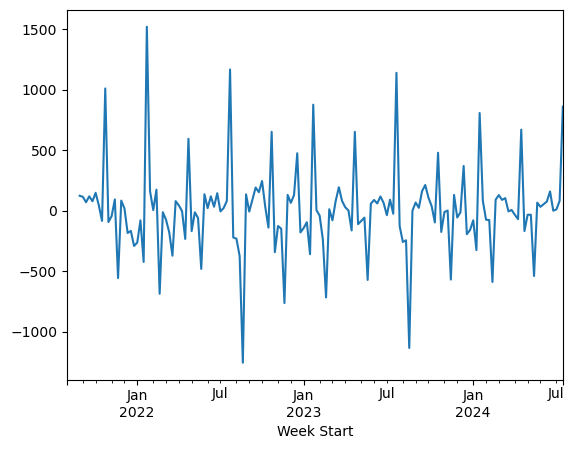

In [50]:
### Now data is stationary as p value is less than .05
df['Seasonal First Difference'].plot()

In [20]:
#### Auto Regressive Model- Autocorrelation and Partial Autocorrelation

### For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

In [51]:
#### ARIMA has 3 parts- auto regressive (AR model), differencing and moving average
#### AR Model is done with PACF (Partial Autocorrelation)
### p- AR model lags,d- differencing,q- Moving avg lags
### we have 26 NaN so 27th onwards data is coming
# p=1, q= acf better than pacf as no exponentail decrease =0 or 1, d=1 as 1 time it has been shifted
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Bookings'],order=(1,1,1),seasonal_order=(1,1,1,4))

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [52]:
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10783D+00    |proj g|=  7.38647D-02

At iterate    5    f=  7.01960D+00    |proj g|=  3.78118D-02

At iterate   10    f=  7.00664D+00    |proj g|=  1.93264D-03

At iterate   15    f=  7.00498D+00    |proj g|=  6.22157D-03

At iterate   20    f=  6.92316D+00    |proj g|=  7.96245D-02

At iterate   25    f=  6.87543D+00    |proj g|=  1.14503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     38      1     0     0   

 This problem is unconstrained.


<Axes: xlabel='Week Start'>

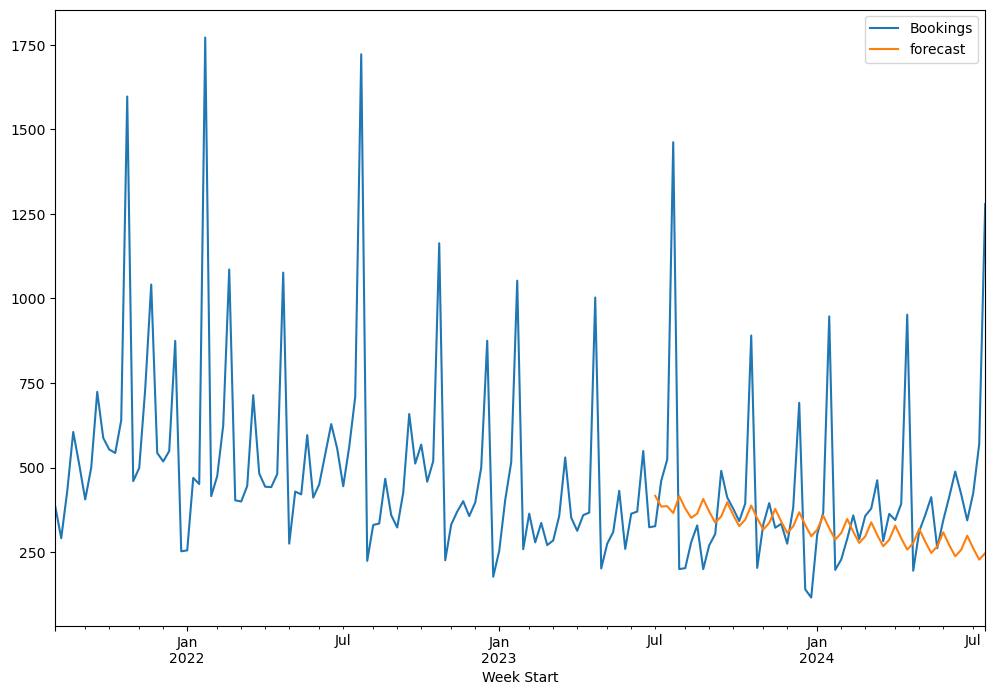

In [53]:
df['forecast']=results.predict(start=100, end = 155, dynamic=True) # testing the model performance with sample input
df[['Bookings','forecast']].plot(figsize=(12,8))

In [54]:
### Predicting future forecast
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+DateOffset(weeks=x)for x in range(0,53)] # Creating future weeks- 53 weeks placeholder

In [55]:
future_dataset_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_dataset_df.index.name = 'Week Start'

In [56]:
future_dataset_df.head()

,Bookings,Seasonal First Difference,forecast
Week Start,,,
2024-07-28,NaN,NaN,NaN
2024-08-04,NaN,NaN,NaN
2024-08-11,NaN,NaN,NaN
2024-08-18,NaN,NaN,NaN
2024-08-25,NaN,NaN,NaN


In [57]:
future_df=pd.concat([df,future_dataset_df])

/var/folders/qg/9qnm2g51701gxcxzzwr1q97c0000gn/T/ipykernel_89621/674726799.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df,future_dataset_df])


<Axes: xlabel='Week Start'>

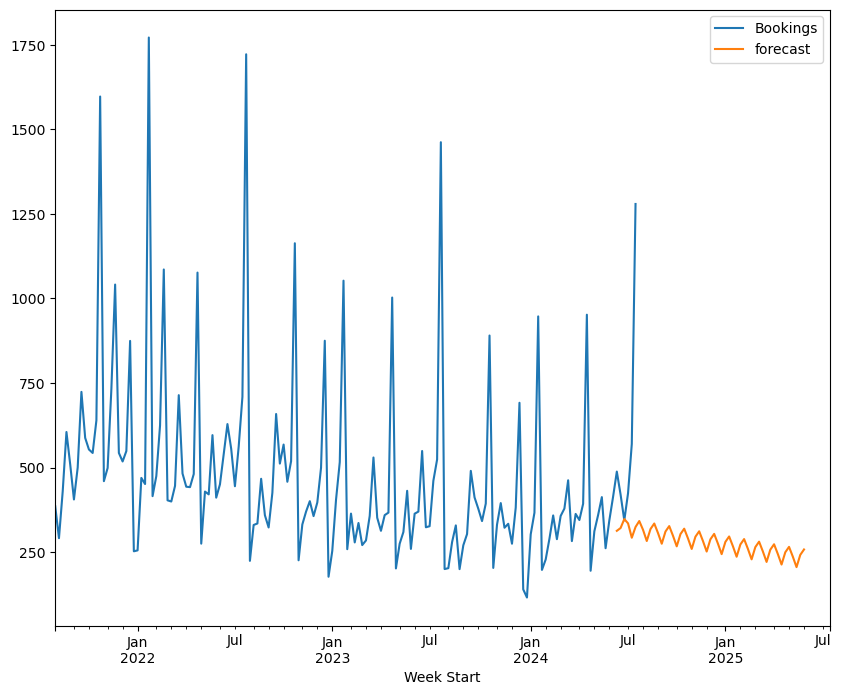

In [24]:
future_df['forecast']=results.predict(start=150, end=200, dynamic=True)
future_df[['Bookings','forecast']].plot(figsize=(10,8))

In [58]:
future_df[future_df['forecast'].notna()] # check the forecast values along with the bookings for the last weeks

,Bookings,Seasonal First Difference,forecast
Week Start,,,
2023-07-02,326.440856,-36.965030,416.247662
2023-07-09,460.724917,91.077859,384.644311
2023-07-16,523.770907,-25.115200,385.658502
2023-07-23,1462.329309,1139.083001,365.397446
2023-07-30,199.600827,-126.840029,415.418328
2023-08-06,202.289681,-258.435237,378.792695
2023-08-13,279.357089,-244.413818,351.046598
2023-08-20,328.750527,-1133.578782,363.895858
2023-08-27,199.421478,-0.179349,406.987741
